In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

## Objectives: 

* Gather the Data. 
* Basic data exploration
* Creating and training model (Using Transfer learning through mobilenet architecture.)
* Performance check and optimisation if needed. 
* Report

### 1. Loading the Images and Visualising them (Understanding the dataset)

In [3]:
# Initial data directory set up

current_dir = os.getcwd()
training_dir_name = "cat_dog_data/training_set"
testing_dir_name = "cat_dog_data/test_set"
class_subdirs = ['cats', 'dogs']

training_dir = os.path.join(current_dir, training_dir_name)
testing_dir = os.path.join(current_dir, testing_dir_name)

In [4]:

tf_seed_val = 42

train_data, validation_data = keras.preprocessing.image_dataset_from_directory(training_dir,\
                                                              labels='inferred',\
                                                              color_mode='rgb',\
                                                              image_size=(224 ,224),\
                                                              label_mode="binary",\
                                                              shuffle=True,\
                                                              validation_split=0.3,
                                                              subset="both",
                                                              seed=tf_seed_val)

# test_data = keras.utils.image_dataset_from_directory(
#     testing_dir_name,
#     batch_size = 32, 
#     image_size=(256, 256),
#     label_mode="binary",
#     shuffle=True,
#     seed = 42
# )

Found 4969 files belonging to 2 classes.
Using 3479 files for training.
Using 1490 files for validation.


In [5]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

**Visualising some of the images present in the above dataset**

**We can see that keras has loaded the images onto its built-in BatchDataset.**

* labels="inferred" takes in the class names by segregating the directory names in the local filesystem. EG: "training_set/cats" and "training_set/dogs" as two classes. 
* Since We have no explicitly stated the class names, 0 and 1 have been substituted for the above class names based on directory name in fs (here, cats(0)/dogs(1))

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random

def plot_random_batch_images(data, is_normalised=False):
    """
    Function takes in a random batch and and displays specified number of images.
    data: DataSet/BatchDataSet
    is_normalised: Whether data is normalised. If data is not normalised, works between 0-255 in integer range
        if data is normalised, works with float values
    """
    plt.figure(figsize=(12, 8))
    rand_number = random.randint(0, len(data))
    if is_normalised:
        for images, labels in data.take(rand_number):
            for i in range(9):
                ax = plt.subplot(3, 3, i+1)
                plt.imshow(images[i].numpy())
                plt.title(int(labels[i]))
                plt.axis('off')
    else:
        for images, labels in data.take(rand_number):
            for i in range(9):
                ax = plt.subplot(3, 3, i+1)
                plt.imshow(images[i].numpy().astype('uint8'))
                plt.title(int(labels[i]))
                plt.axis('off')

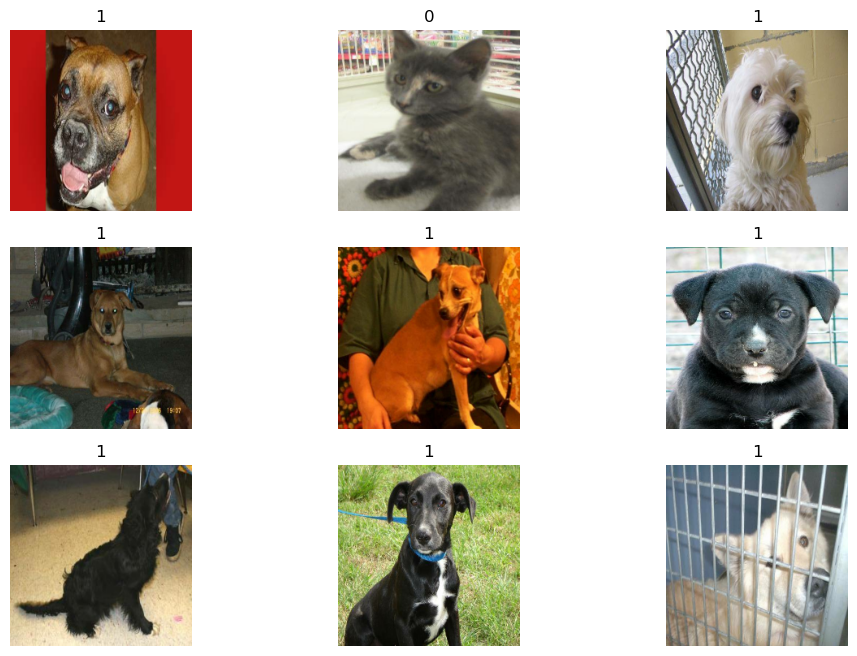

In [7]:
plot_random_batch_images(train_data, False)

### 2. Data augmentation

Our data will be augmented for the following end goal:
* Normalising data (bringing values between 0 and 1).
* Inducing Randomness into our dataset (flipping, rotating and so on...)

The above steps help in:
* Improving randomness and reducing overfitting by making it harder for models to learn patterns
* The above helps increase the model's accuracy in real world scenarios. 

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, Rescaling, Dense

In [9]:
augment_data = Sequential([
    Rescaling(1./255), # Normalising the data, this will help in performance.
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])

train_data_augm = train_data.map(lambda x, y: (augment_data(x), y)) 

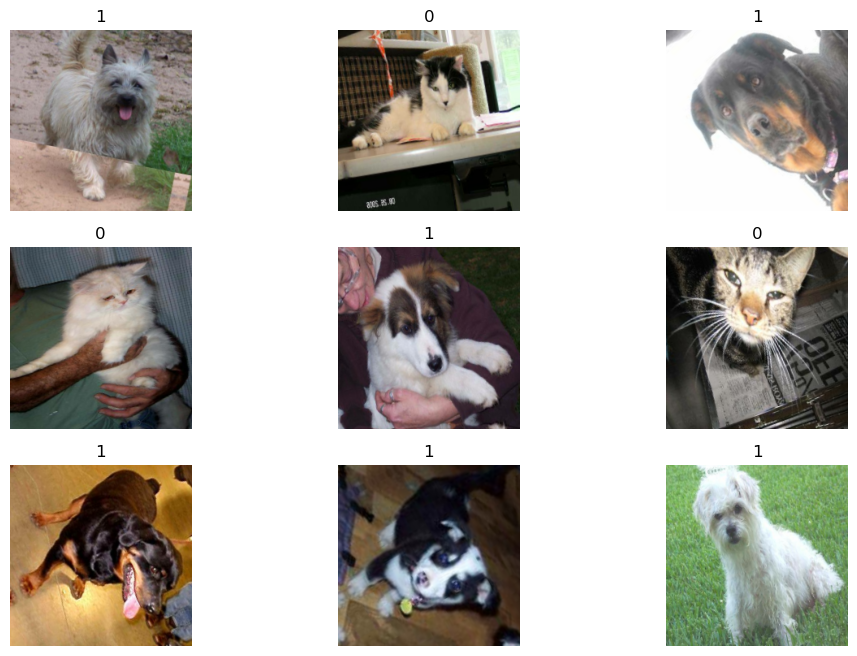

In [10]:
# Visualising our augmented data
plot_random_batch_images(train_data_augm,1)

# Now that we have our data, we need to create a training model

## Typical transfer-learning workflow:

* Instantiate a base model and load its pre-trained weights.
* Freeze all layers in the base model by setting `trainable-False`
* Create a new model on top of the output of one(or several) layers from the base model.
* Train your new model on your new Dataset.

## Alternate, More lightweight workflow:

* Instantiate a model and load pre-trained weights into it. 
2. Run new dataset through it and record the output of one(or several)layers from the base model. This is called **feature extraction**.
3. Use tha toutput as input data for a new, smaller model

We will be using the`MobileNet Architecture` that comes with `tensorflow.keras.applications`. 

The MobileNet Architecture is a CNN architecture designed for efficient and lightweight deep learning on mobile and embedded devices. Primarily goal of the architecture is to enable real-time image classification and object detection tasks on resource-contrained devices such as smartphones

Uses Depth-wise separable convolutions (separate spatial convolution and depthwise convolution.). This separation reduces the computational complexity and number of parameters compared to traditional convolution layers.

It Consists of series of depthwise separable convolution layers, followed by Global average pooling layer and a fully connected layer for classification.  

In [10]:
from tensorflow.keras.applications import MobileNetV2

In [11]:
mobile_net_base = MobileNetV2(weights="imagenet", # weights pre-trained on ImageNet are loaded.
                              input_shape=(224, 224, 3),
                             include_top=False) # Do not include the ImageNet classifier at the top.

mobile_net_base.trainable = False # Setting the weights of this model to non-trainable.


In [13]:
mobile_net_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

Now that we have our base layer which is based on the MobileNet architecture, we need to calibrate it to our use case. 


`tf.keras.layers.Input`: is used to instatiate a Keras Tensor. Keras Tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model by just knowing the inputs and outputs of the model. 

`tf.keras.layers.BatchNormalization()`: Maintains the mean output close to 0 and the output standard deviation to 1.
Batch normalization runs in two modes :
* **Inference Mode** - This is when the model is predicting or when training is set to True.
* **Training Mode** - This is when fit is called on the model. In this scenario the weights in the Batch Normalization layers are allowed to be updated.

## 3. Feature exctraction and model training using MobileNetv2. 

> We will be using MobileNetv2 (with weights loaded on from the model's performance on the ImageNet Dataset.) with an extra layer consisting of `tf.keras.layers.Dense` which will form our base layer, from here we will be improving the performance of the model. 

> **Note:** Since we are working with Binary classification, we use the Dense layer at the end to make our probabilities. The Dense layer does not consider spatial data and expects a 1-D input Vector. 

There are two layers that we can use in this situation: 
* Flatten layer: which converts the 2D spatial data to 1D spatial data. The flatten layer does not account for spatial data, merely unwrapping the 2-d space row by row. This can mean that one feature which was clustered next to an important feature, might now be represented very far away, not preserving spatial data in anyway. 
* Global Average Pooling Layer: Preserves the feature data by averaging the value of each feature map across it's domain (visualise it similar to how COnv2D might work, with kernels.).And returns this in a 1D vector. This preserves most features.
* MaxPooling: Takes the Max value in the kernel and stitches/appends to the existing 1-D vector. 

In [14]:
# Create the model

base_model = Sequential([
    mobile_net_base, 
    tf.keras.layers.Flatten(),
    Dense(1, activation="sigmoid") # 1 neuron since output shape will be (1,) predicting the class
])

# Compile the model
base_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Default learning rate for Adam
    metrics=["accuracy"]
)

In [15]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
# Fit the model
base_history = base_model.fit(
    train_data_augm,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data)
)

Epoch 1/5
109/109 [==============================] - 61s 524ms/step - loss: 0.4896 - accuracy: 0.9365 - val_loss: 1.1029 - val_accuracy: 0.7477
Epoch 2/5
109/109 [==============================] - 55s 504ms/step - loss: 0.2670 - accuracy: 0.9652 - val_loss: 1.5021 - val_accuracy: 0.6510
Epoch 3/5
109/109 [==============================] - 55s 502ms/step - loss: 0.2844 - accuracy: 0.9695 - val_loss: 1.5789 - val_accuracy: 0.6685
Epoch 4/5
109/109 [==============================] - 55s 503ms/step - loss: 0.2586 - accuracy: 0.9733 - val_loss: 1.8730 - val_accuracy: 0.6799
Epoch 5/5
109/109 [==============================] - 54s 499ms/step - loss: 0.2379 - accuracy: 0.9764 - val_loss: 2.4330 - val_accuracy: 0.7644


In [17]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

### Plot model loss curves and accuracy using the history of the model training

In [4]:
def plot_loss_curves(model_history):
    """
    Takes in the History of a model. Plots the loss and accuracy. 
    Note current metric used is accuracy, if any other metric is specified
    during model compilation, this function will break. 
    
    Args:
        model_history: History Object of the model
        
    Returns:
        Plots two graphs consisting of loss curves and accuracy curves of model history
    """
    
#     Get values for loss and accuracy
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    
    epochs = list(range(len(model_history.history['loss'])))
    print(val_loss)
    
#     Plot the loss curves
    plt.figure()
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="validation loss")
    plt.title('Model Loss')
    plt.legend();
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training accuracy")
    plt.plot(epochs, val_accuracy, label="validation accuracy")
    plt.title("Model Accuracy")
    plt.legend();

[1.1028984785079956, 1.502109169960022, 1.5789200067520142, 1.873002529144287, 2.4330220222473145]


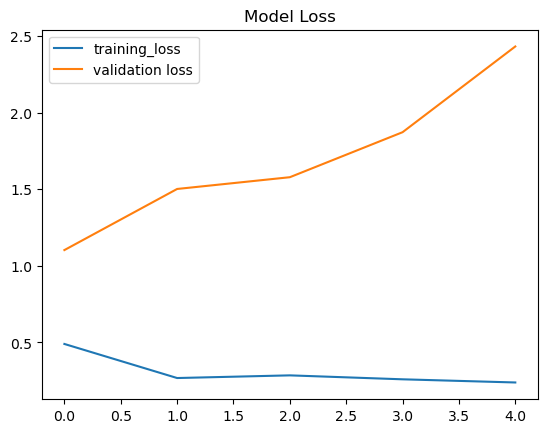

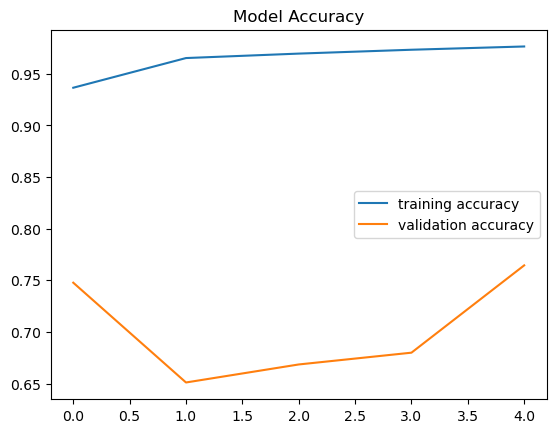

In [19]:
plot_loss_curves(base_history)

We can see that the model is learning something which is shown in the loss curves and the training accuracy. But, in the real world, We can see that the loss is increasing and the validation accuracy does not follow the accuracy of training.

* Loss curves diverging might be a case of our model over-fitting the data. This might be the cause for low Validation accuracy as well. Our model has learnt the patterns in the validation dataset too well. 

How can we solve this? 
* Changing the architecture.
* Hyperparameter tuning. 

Changing the architecture using other layers that perform preserve spatial data can help us. 

Some of them are: 
* GlobalAvgPooling, 
* GlobalMaxPooling.

In [20]:
!nvidia-smi

Sun Jul 23 23:29:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8               8W / 160W |    607MiB /  8188MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

modifying the base layer, removing Flatten and attempting to preserve spatial information consiely within a 1-D Vector

In [21]:
tf.random.set_seed(42)

# Create the model
base_model_v1 = Sequential([
    mobile_net_base,
    tf.keras.layers.GlobalAvgPool2D(),
    Dense(1, activation="sigmoid")
])

# Compile the model
base_model_v1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [22]:
# Fit the model
history_v1 = base_model_v1.fit(
    train_data_augm,
    epochs=5,
    steps_per_epoch=len(train_data_augm),
    validation_data=validation_data,
    validation_steps=len(validation_data)
)

Epoch 1/5
109/109 [==============================] - 60s 510ms/step - loss: 0.2133 - accuracy: 0.9204 - val_loss: 0.5212 - val_accuracy: 0.7879
Epoch 2/5
109/109 [==============================] - 54s 499ms/step - loss: 0.1026 - accuracy: 0.9652 - val_loss: 0.5298 - val_accuracy: 0.7933
Epoch 3/5
109/109 [==============================] - 54s 497ms/step - loss: 0.0886 - accuracy: 0.9687 - val_loss: 0.5373 - val_accuracy: 0.7832
Epoch 4/5
109/109 [==============================] - 56s 510ms/step - loss: 0.0785 - accuracy: 0.9724 - val_loss: 0.5422 - val_accuracy: 0.7906
Epoch 5/5
109/109 [==============================] - 55s 504ms/step - loss: 0.0748 - accuracy: 0.9733 - val_loss: 0.5461 - val_accuracy: 0.7866


[0.5212363600730896, 0.5297979712486267, 0.53730708360672, 0.5422465801239014, 0.546114981174469]


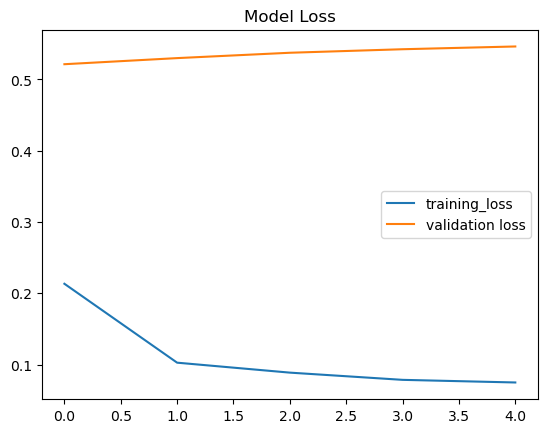

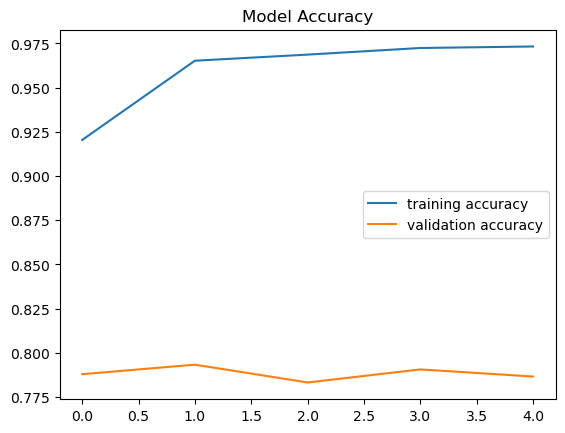

In [23]:
plot_loss_curves(history_v1)

> Great! Our validation accuracy has increased and our loss has decreased. But, looking into the graphs we can see that There is no convergence occuring. 

> Let's see what we can achieve using the MaxPooling Layer now. MaxPooling layer intensifies regions with strong feature patches, and kind of, tuning up the presense of features in the spatial domain. But, it needs a Flatten layer, which might still cause us issues.
 

## Using `MaxPool2D()`+`Flatten()` as our layer

In [24]:
from tensorflow.keras.layers import Flatten, MaxPool2D, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [25]:
tf.random.set_seed(42)

base_model_v2 = Sequential([
    mobile_net_base,
    tf.keras.layers.MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation="sigmoid")
])

base_model_v2.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [26]:
# Fit the model
history_v2 = base_model_v2.fit(
    train_data_augm,
    epochs=5,
    steps_per_epoch=len(train_data_augm),
    validation_data=validation_data,
    validation_steps=len(validation_data)
)

Epoch 1/5
109/109 [==============================] - 60s 511ms/step - loss: 0.2719 - accuracy: 0.9333 - val_loss: 0.7633 - val_accuracy: 0.6383
Epoch 2/5
109/109 [==============================] - 56s 511ms/step - loss: 0.1480 - accuracy: 0.9621 - val_loss: 1.2806 - val_accuracy: 0.8054
Epoch 3/5
109/109 [==============================] - 55s 504ms/step - loss: 0.1077 - accuracy: 0.9692 - val_loss: 1.4089 - val_accuracy: 0.8054
Epoch 4/5
109/109 [==============================] - 55s 502ms/step - loss: 0.1159 - accuracy: 0.9713 - val_loss: 1.3531 - val_accuracy: 0.5107
Epoch 5/5
109/109 [==============================] - 54s 498ms/step - loss: 0.1034 - accuracy: 0.9756 - val_loss: 1.8872 - val_accuracy: 0.8060


[0.7633185982704163, 1.280603289604187, 1.4089189767837524, 1.3531312942504883, 1.887154221534729]


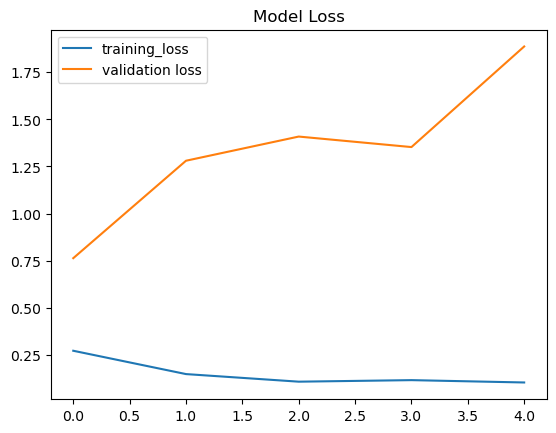

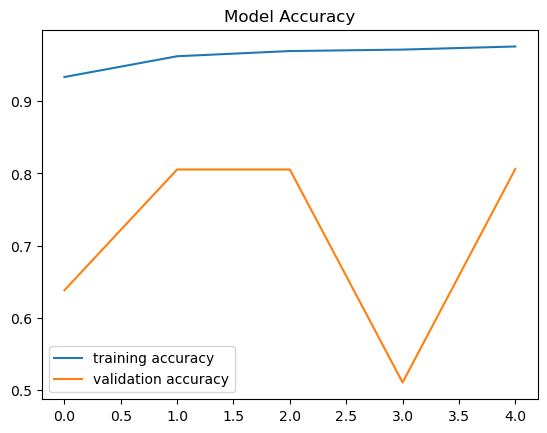

In [27]:
plot_loss_curves(history_v2)

We can see that the loss and accuracy curves havent stabilised. Lets give the model a chance by increasing the number of epochs.

In [28]:
tf.random.set_seed(42)

base_model_v2_1 = Sequential([
    mobile_net_base,
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation="sigmoid")
])

base_model_v2_1.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [29]:
history_v2_1 = base_model_v2_1.fit(
    train_data_augm,
    epochs=10,
    steps_per_epoch=len(train_data_augm),
    validation_data=validation_data,
    validation_steps=len(validation_data)
)

Epoch 1/10
109/109 [==============================] - 59s 507ms/step - loss: 0.3030 - accuracy: 0.9391 - val_loss: 1.1599 - val_accuracy: 0.4805
Epoch 2/10
109/109 [==============================] - 54s 497ms/step - loss: 0.1920 - accuracy: 0.9609 - val_loss: 0.7487 - val_accuracy: 0.6987
Epoch 3/10
109/109 [==============================] - 54s 497ms/step - loss: 0.1380 - accuracy: 0.9695 - val_loss: 1.4960 - val_accuracy: 0.8054
Epoch 4/10
109/109 [==============================] - 55s 502ms/step - loss: 0.1378 - accuracy: 0.9690 - val_loss: 1.0162 - val_accuracy: 0.7826


KeyboardInterrupt: 

In [ ]:
plot_loss_curves(history_v2_1)

We can see that the losses are still not converging and the accuracy is not generalizing itself. Using `MaxPool2D` in conjunction with `Flatten()` might not be the way forward. 

> Let's try GlobalMaxPool

## Using `GlobalMaxPool2D`

In [ ]:
base_model_v3 = Sequential([
    mobile_net_base,
    GlobalMaxPool2D(),
    Dense(1, activation="sigmoid")
])

base_model_v3.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)ii

In [ ]:
history_v3 = base_model_v3.fit(
    train_data_augm,
    epochs=5,
    steps_per_epoch = len(train_data_augm),
    validation_data=validation_data,
    validation_steps=len(validation_data)
)

In [ ]:
plot_loss_curves(history_v3)

Again, We see that accuracy is not generalising, but, the loss is not convering with the training loss. 

Let's move ahead with GlobalAvgPool2D. 

It will allow us to capture subtle feature differences between the classes in our dataset.

In [ ]:
base_model_v1.summary()

In [ ]:
plot_loss_curves(history_v1)

## Reverting to using `GlobalAveragePool2D`

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os
import matplotlib.pyplot as plt
import numpy as np

In [16]:
current_dir = os.getcwd()
training_dir_name = "cat_dog_data/training_set"
testing_dir_name = "cat_dog_data/test_set"
class_subdirs = ['cats', 'dogs']

training_dir = os.path.join(current_dir, training_dir_name)
testing_dir = os.path.join(current_dir, testing_dir_name)

tf_seed_val = 42

train_data, validation_data = keras.preprocessing.image_dataset_from_directory(training_dir,\
                                                              labels='inferred',\
                                                              color_mode='rgb',\
                                                              image_size=(224 ,224),\
                                                              label_mode="binary",\
                                                              shuffle=True,\
                                                              validation_split=0.5,
                                                              subset="both",
                                                              seed=tf_seed_val)

# test_data = keras.utils.image_dataset_from_directory(
#     testing_dir_name,
#     batch_size = 32, 
#     image_size=(256, 256),
#     label_mode="binary",
#     shuffle=True,
#     seed = 42
# )

Found 4969 files belonging to 2 classes.
Using 2485 files for training.
Using 2484 files for validation.


Rebuilding base_model_v1

In [23]:
INIT_EPOCHS = 5

checkpoint_path="tmp/base_model_v1_checkpoint"

save_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_freq = "epoch"
)

In [8]:
augment_data = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomZoom(0.3),
    layers.RandomRotation(0.3),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.3)
], name="data_augmentation_layer")

In [34]:
mobile_net_base.trainable=False


inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = augment_data(inputs)
x = mobile_net_base(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

base_model_v1 = keras.Model(inputs, outputs)

In [35]:
base_model_v1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

We will first run the code in inference mode for about 10 epochs and see where the loss and accuracy of the model end up.

In [36]:
for i, layer in enumerate(mobile_net_base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [37]:
base_model_v1.compile(
    loss=BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

In [38]:
for layer in base_model_v1.layers:
    print(layer.name, layer.trainable)

input_layer True
mobilenetv2_1.00_224 False
global_average_pooling_layer True
dropout True
output_layer True


We can see that here the mobile net architecture is not trainable. Lets run the model in inference mode, for feature extraction, and increase number of epochs to 15.

In [39]:
base_model_v1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

In [40]:
history_v1_0 = base_model_v1.fit(
    train_data,
    epochs=INIT_EPOCHS,
    steps_per_epoch=int(0.1*len(train_data)),
    validation_data=validation_data,
    validation_steps=int(0.1*len(validation_data)),
    callbacks=[
        save_checkpoint_callback
    ]
)

Epoch 1/5
7/7 [==============================] - 11s 988ms/step - loss: 0.8483 - accuracy: 0.5491 - val_loss: 0.5255 - val_accuracy: 0.7991
Epoch 2/5
7/7 [==============================] - 5s 796ms/step - loss: 0.5429 - accuracy: 0.7768 - val_loss: 0.4822 - val_accuracy: 0.8125
Epoch 3/5
7/7 [==============================] - 5s 784ms/step - loss: 0.5596 - accuracy: 0.7500 - val_loss: 0.4815 - val_accuracy: 0.8125
Epoch 4/5
7/7 [==============================] - 5s 779ms/step - loss: 0.5413 - accuracy: 0.8036 - val_loss: 0.4740 - val_accuracy: 0.8125
Epoch 5/5
7/7 [==============================] - 5s 773ms/step - loss: 0.5577 - accuracy: 0.7946 - val_loss: 0.4714 - val_accuracy: 0.8125


[0.5255159139633179, 0.4821958839893341, 0.4814610183238983, 0.4739910662174225, 0.4714184105396271]


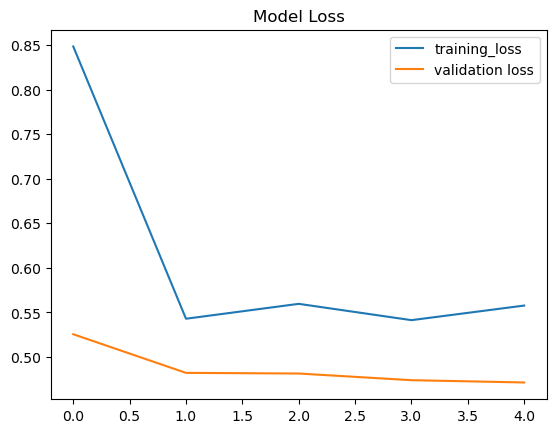

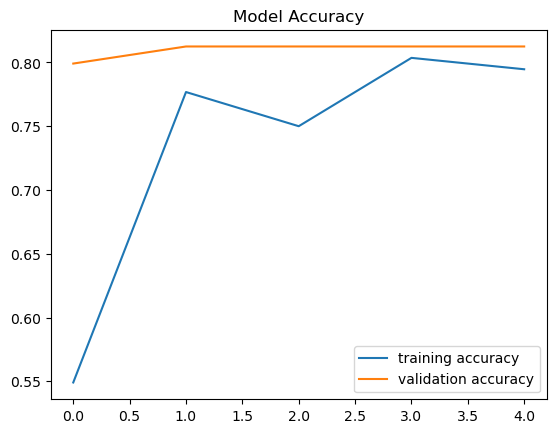

In [41]:
plot_loss_curves(history_v1_0)

In [42]:
base_model_v1.evaluate(validation_data)

78/78 [==============================] - 25s 321ms/step - loss: 0.4799 - accuracy: 0.8104


[0.47991859912872314, 0.8103864789009094]

Over the whole validation set, we can see that the accuracy is coming to ~83%. Let us try to fine tune the model. 
Since the MobileNetArchitecture has COnv2D layer towards the end, let us allow this layer to train and see if it helps improve our validation results. We will be ignoring batchnormalisation layers. 

In [43]:
mobile_net_base.trainable = False

In [44]:
for layer in mobile_net_base.layers[:-6:-1]:
    if ('bn'.upper() in layer.name.upper()):
        print("Batch Normalization layer")
    else:
        layer.trainable=True

Batch Normalization layer
Batch Normalization layer


In [45]:
for i, layer in enumerate(mobile_net_base.layers):

    print(i+1, layer.name, layer.trainable)

1 input_1 False
2 Conv1 False
3 bn_Conv1 False
4 Conv1_relu False
5 expanded_conv_depthwise False
6 expanded_conv_depthwise_BN False
7 expanded_conv_depthwise_relu False
8 expanded_conv_project False
9 expanded_conv_project_BN False
10 block_1_expand False
11 block_1_expand_BN False
12 block_1_expand_relu False
13 block_1_pad False
14 block_1_depthwise False
15 block_1_depthwise_BN False
16 block_1_depthwise_relu False
17 block_1_project False
18 block_1_project_BN False
19 block_2_expand False
20 block_2_expand_BN False
21 block_2_expand_relu False
22 block_2_depthwise False
23 block_2_depthwise_BN False
24 block_2_depthwise_relu False
25 block_2_project False
26 block_2_project_BN False
27 block_2_add False
28 block_3_expand False
29 block_3_expand_BN False
30 block_3_expand_relu False
31 block_3_pad False
32 block_3_depthwise False
33 block_3_depthwise_BN False
34 block_3_depthwise_relu False
35 block_3_project False
36 block_3_project_BN False
37 block_4_expand False
38 block_4_exp

In [46]:
base_model_v1.load_weights(checkpoint_path)

In [47]:
"""
Model needs to be recompiled since we have made changes to the mobilenet arch.
Now that our model has been trained for feature extraction, we are going to run it training mode from the initial epoch.
Since we are fine tuning here, the learning rate has been reduced by a factor of 10x. 
"""

base_model_v1.compile(
    loss=BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

In [48]:
total_epochs = INIT_EPOCHS + 10
history_v1_1 = base_model_v1.fit(
    train_data,
    initial_epoch=INIT_EPOCHS,
    epochs=total_epochs,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=int(0.1*len(validation_data))
)

Epoch 6/15
78/78 [==============================] - 33s 366ms/step - loss: 0.5022 - accuracy: 0.7952 - val_loss: 0.4418 - val_accuracy: 0.8125
Epoch 7/15
78/78 [==============================] - 28s 351ms/step - loss: 0.4701 - accuracy: 0.8032 - val_loss: 0.4400 - val_accuracy: 0.8348
Epoch 8/15
78/78 [==============================] - 28s 351ms/step - loss: 0.4487 - accuracy: 0.8117 - val_loss: 0.4077 - val_accuracy: 0.8259
Epoch 9/15
78/78 [==============================] - 28s 351ms/step - loss: 0.4211 - accuracy: 0.8193 - val_loss: 0.3994 - val_accuracy: 0.8304
Epoch 10/15
78/78 [==============================] - 28s 353ms/step - loss: 0.4218 - accuracy: 0.8141 - val_loss: 0.3951 - val_accuracy: 0.8304
Epoch 11/15
78/78 [==============================] - 27s 350ms/step - loss: 0.4122 - accuracy: 0.8169 - val_loss: 0.3863 - val_accuracy: 0.8304
Epoch 12/15
78/78 [==============================] - 28s 353ms/step - loss: 0.4109 - accuracy: 0.8306 - val_loss: 0.4076 - val_accuracy: 0.8

In [49]:
base_model_v1.evaluate(validation_data)

78/78 [==============================] - 25s 319ms/step - loss: 0.3936 - accuracy: 0.8305


[0.3935892581939697, 0.8305153250694275]

### Resetting the model. Since there is divergence of data, our model might be overfitting the data. 

In [50]:
# Load weights and verify
base_model_v1.load_weights(checkpoint_path)

base_model_v1.evaluate(validation_data)

78/78 [==============================] - 25s 319ms/step - loss: 0.4799 - accuracy: 0.8104


[0.47991859912872314, 0.8103864789009094]

In [44]:
def plot_combined_history(prev_hist, cur_hist):
    """
    Takes the old and new History objects, combines them, and returns a plot
    Args:
        prev_hist = previous History object
        cur_hist = current History object
        
    Returns:
        A plot with combined Histories
    """
    
#     Get previous history varaibles from History object
    prev_loss = prev_hist.history['loss']
    prev_val_loss = prev_hist.history['val_loss']
    
    prev_acc = prev_hist.history['accuracy']
    prev_val_acc = prev_hist.history['val_accuracy']
    
#     Get cur_hist variables
    cur_loss=cur_hist.history['loss']
    cur_val_loss = cur_hist.history['val_loss']
    
    cur_acc = cur_hist.history['accuracy']
    cur_val_acc = cur_hist.history['val_accuracy']
    
    loss = prev_loss + cur_loss
    val_loss = prev_val_loss + cur_val_loss
    
    accuracy = prev_acc + cur_acc
    val_accuracy = prev_val_acc + cur_val_acc
    
    total_epochs = range(len(loss))
    
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs,loss, label="training loss")
    plt.plot(total_epochs, val_loss, label="validation loss")
    plt.axvline(len(prev_loss), color="green", label="checkpoint")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend();
    
    plt.subplot(1, 2, 2)
    plt.plot(total_epochs, accuracy, label="training accuracy")
    plt.plot(total_epochs, val_accuracy, label="validation accuracy")
    plt.axvline(len(prev_loss), color="g", label="Checkpoint")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend();

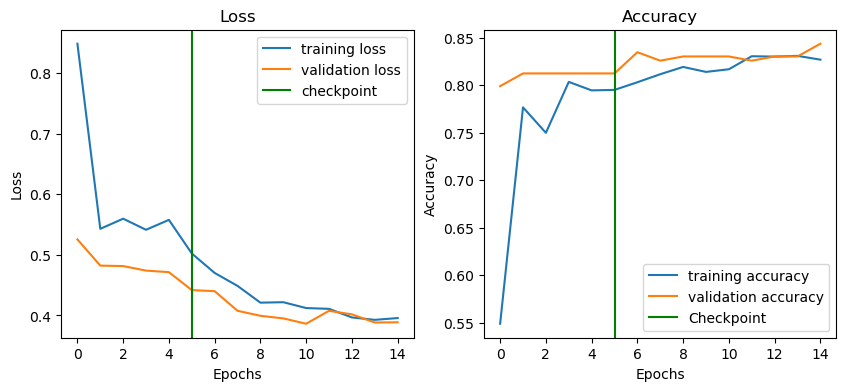

In [52]:
plot_combined_history(history_v1_0, history_v1_1)

# Testing with a clone model

### Objectives:
* See if we can fine tune using learning rate. 
* Find other ways to improve the model

In [53]:
test_bm_1 = keras.models.clone_model(base_model_v1)
# test_mbv2 = keras.applications.MobileNetV2(weights='imagenet',input_shape=(224, 224, 3), include_top=False)

In [54]:
for i, layer in enumerate(test_bm_1.layers):
    if 'mobilenet' in layer.name:
        layer.trainable=False
    print(layer.name, layer.trainable)

input_layer True
mobilenetv2_1.00_224 False
global_average_pooling_layer True
dropout True
output_layer True


In [55]:
class LrScheduler(keras.callbacks.Callback):
    def __init__(self, start_epoch, base, step, mode='dec'):
        """
        start_epoch: epoch at which to start applying lr decay
        lrd: Learning rate decay
        mode : inc/dec
        """
        super().__init__()
        self.start_epoch =start_epoch
        self.base = base
        self.step = step
        self.mode = mode
        self.losses = []
        self.lrs = []
        
    def on_epoch_end(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError("Optimizer has no attribute 'lr'")
        cur_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        self.losses.append(logs['loss'])
        if epoch >= self.start_epoch:
            # Get the current Learning Rate from the optimizer
            if (self.mode.upper() == 'INC'):
                new_lr = cur_lr + self.step(epoch, self.base)
            else:
                new_lr = cur_lr - self.step(epoch, self.base)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            self.lrs.append(new_lr)
            print(f"\nLR at epoch{epoch} changed to {new_lr} from {cur_lr}")
        else:
            self.lrs.append(cur_lr)
            
    def plot_lr(self):
        plt.plot(self.lrs, self.losses)
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title("Learning Rate Vs Loss")

In [56]:
def create_schedule_step(epoch, base):
    return 0.00012
    
lr_callback = LrScheduler(
    start_epoch=0, 
    base=1e-4,
    step=create_schedule_step,
    mode='inc'
)

In [57]:
test_bm_1.compile(
    loss=BinaryCrossentropy(),
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

In [58]:
history_test_inc = test_bm_1.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=int(0.25*len(validation_data)),
    callbacks=[lr_callback]
)

Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.7940
LR at epoch0 changed to 0.0011200000474974514 from 0.0010000000474974513
78/78 [==============================] - 36s 411ms/step - loss: 0.6797 - accuracy: 0.7940 - val_loss: 0.6661 - val_accuracy: 0.8306
Epoch 2/10
78/78 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.8012
LR at epoch1 changed to 0.0012400000299140812 from 0.001120000029914081
78/78 [==============================] - 31s 399ms/step - loss: 0.6573 - accuracy: 0.8012 - val_loss: 0.6410 - val_accuracy: 0.8306
Epoch 3/10
78/78 [==============================] - ETA: 0s - loss: 0.6346 - accuracy: 0.8012
LR at epoch2 changed to 0.001360000012330711 from 0.0012400000123307109
78/78 [==============================] - 31s 397ms/step - loss: 0.6346 - accuracy: 0.8012 - val_loss: 0.6157 - val_accuracy: 0.8306
Epoch 4/10
78/78 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.8012
LR at epoch

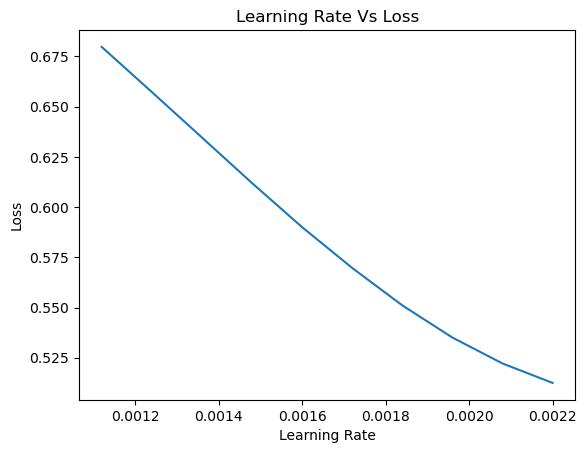

In [59]:
lr_callback.plot_lr()

[0.6661453247070312, 0.6410300731658936, 0.6157463192939758, 0.5901961326599121, 0.5658560991287231, 0.5431627035140991, 0.5221428275108337, 0.5039646625518799, 0.4894019663333893, 0.47796717286109924]


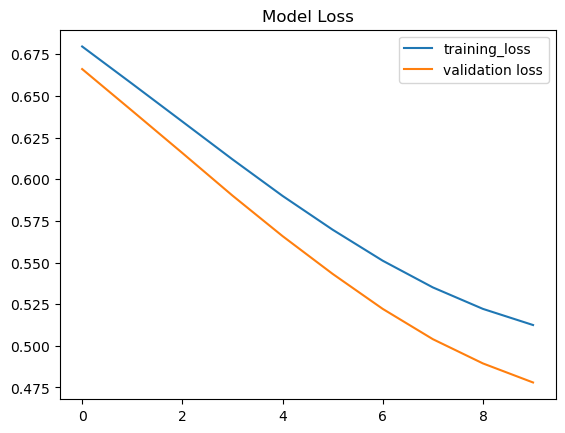

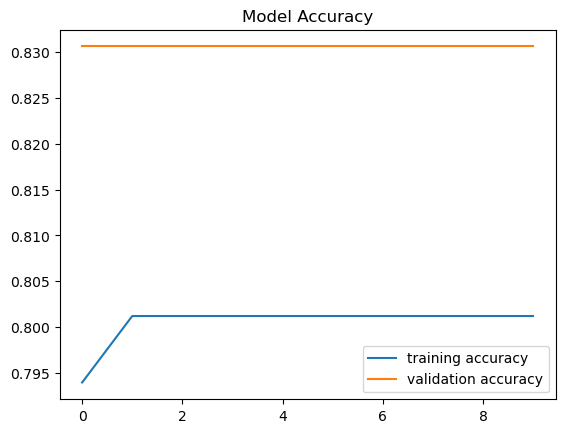

In [60]:
plot_loss_curves(history_test_inc)

In [61]:
test_bm_1 = keras.models.clone_model(base_model_v1)
for i, layer in enumerate(test_bm_1.layers):
    if 'mobilenet' in layer.name:
        layer.trainable=False
    print(layer.name, layer.trainable)

input_layer True
mobilenetv2_1.00_224 False
global_average_pooling_layer True
dropout True
output_layer True


In [62]:
test_bm_1.compile(
    loss=BinaryCrossentropy(),
    optimizer=keras.optimizers.RMSprop(learning_rate=0.002),
    metrics=["accuracy"]
)

history_test_2 = test_bm_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch = len(train_data),
    validation_data=validation_data,
    validation_steps=int(0.25 *len(validation_data))
)

Epoch 1/5
78/78 [==============================] - 37s 417ms/step - loss: 0.6668 - accuracy: 0.7924 - val_loss: 0.6412 - val_accuracy: 0.8306
Epoch 2/5
78/78 [==============================] - 31s 401ms/step - loss: 0.6276 - accuracy: 0.8012 - val_loss: 0.6010 - val_accuracy: 0.8306
Epoch 3/5
78/78 [==============================] - 32s 403ms/step - loss: 0.5950 - accuracy: 0.8012 - val_loss: 0.5670 - val_accuracy: 0.8306
Epoch 4/5
78/78 [==============================] - 31s 403ms/step - loss: 0.5680 - accuracy: 0.8012 - val_loss: 0.5388 - val_accuracy: 0.8306
Epoch 5/5
78/78 [==============================] - 32s 405ms/step - loss: 0.5465 - accuracy: 0.8012 - val_loss: 0.5156 - val_accuracy: 0.8306


# FINALLY REALISING THE MISTAKE I MADE. 

passing in inputs to mobileNetBaseV2 without augmenting data!!!! 

Lets rectify and check for efficiency. 

The model has been over fitting this whole time.

In [84]:
inputs = layers.Input(shape=(224, 224, 3), name="Input_layer")
x = augment_data(inputs)
x = mobile_net_base(x, training=False)
x = layers.GlobalAvgPool2D(name="gl_avg_pooling_layer")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

cd_classifier = keras.Model(inputs, outputs)

In [85]:
cd_classifier.compile(
    loss=BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=["accuracy"])

In [86]:
mobile_net_base.trainable=False
for ind, layer in enumerate(cd_classifier.layers[2].layers):
    print(ind+1, layer.name, layer.trainable)

1 input_1 False
2 Conv1 False
3 bn_Conv1 False
4 Conv1_relu False
5 expanded_conv_depthwise False
6 expanded_conv_depthwise_BN False
7 expanded_conv_depthwise_relu False
8 expanded_conv_project False
9 expanded_conv_project_BN False
10 block_1_expand False
11 block_1_expand_BN False
12 block_1_expand_relu False
13 block_1_pad False
14 block_1_depthwise False
15 block_1_depthwise_BN False
16 block_1_depthwise_relu False
17 block_1_project False
18 block_1_project_BN False
19 block_2_expand False
20 block_2_expand_BN False
21 block_2_expand_relu False
22 block_2_depthwise False
23 block_2_depthwise_BN False
24 block_2_depthwise_relu False
25 block_2_project False
26 block_2_project_BN False
27 block_2_add False
28 block_3_expand False
29 block_3_expand_BN False
30 block_3_expand_relu False
31 block_3_pad False
32 block_3_depthwise False
33 block_3_depthwise_BN False
34 block_3_depthwise_relu False
35 block_3_project False
36 block_3_project_BN False
37 block_4_expand False
38 block_4_exp

In [87]:
new_checkpoint = "tmp/cd_classifier_checkpoint"
cd_checkpoint = keras.callbacks.ModelCheckpoint(new_checkpoint)

cd_history=cd_classifier.fit(
    train_data,
    epochs=INIT_EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=int(0.25*len(validation_data)),
    callbacks=[cd_checkpoint]
)

Epoch 1/5


78/78 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8467WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


78/78 [==============================] - 116s 1s/step - loss: 0.3702 - accuracy: 0.8467 - val_loss: 0.1928 - val_accuracy: 0.9474
Epoch 2/5
78/78 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9002WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


78/78 [==============================] - 105s 1s/step - loss: 0.2565 - accuracy: 0.9002 - val_loss: 0.1279 - val_accuracy: 0.9688
Epoch 3/5
78/78 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9078WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


78/78 [==============================] - 104s 1s/step - loss: 0.2347 - accuracy: 0.9078 - val_loss: 0.1301 - val_accuracy: 0.9638
Epoch 4/5
78/78 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9082WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


78/78 [==============================] - 107s 1s/step - loss: 0.2243 - accuracy: 0.9082 - val_loss: 0.1156 - val_accuracy: 0.9671
Epoch 5/5
78/78 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9159WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


INFO:tensorflow:Assets written to: tmp\cd_classifier_checkpoint\assets


78/78 [==============================] - 107s 1s/step - loss: 0.2176 - accuracy: 0.9159 - val_loss: 0.1260 - val_accuracy: 0.9572


[0.19278721511363983, 0.1278689205646515, 0.13011713325977325, 0.11564839631319046, 0.12599147856235504]


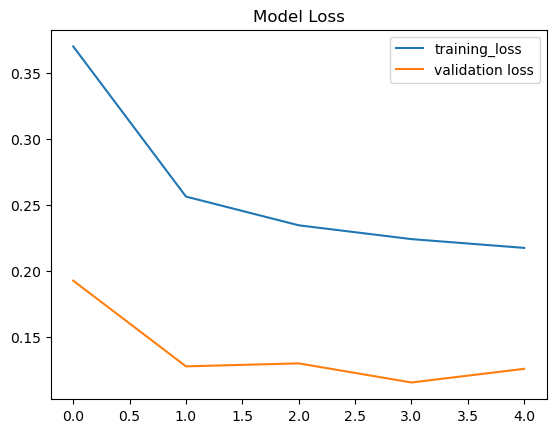

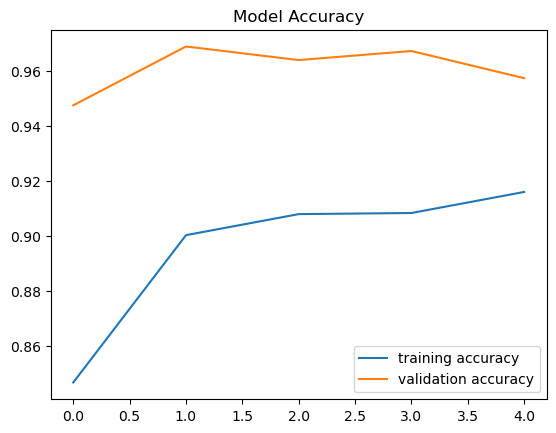

In [89]:
plot_loss_curves(cd_history)

In [90]:
cd_classifier.evaluate(validation_data)

78/78 [==============================] - 27s 344ms/step - loss: 0.1356 - accuracy: 0.9581


[0.1356416642665863, 0.9581320285797119]

### Lets try to fine tune the model now 

## 1.Keep `BatchNormalization` frozen.

In [65]:
checkpoint_path="tmp/cd_classifier_ckpt"
cd_classifier.save_weights(checkpoint_path)

In [83]:
cd_classifier.load_weights(checkpoint_path)

In [67]:
for ind, layer in enumerate(mobile_net_base.layers[:-6:-1]):
    if 'bn'.upper() in layer.name.upper():
        print("Batch normalisation layer, no changes during training")
    else:
        layer.trainable=True
        print(layer.name, layer.trainable)

out_relu True
Batch normalisation layer, no changes during training
Conv_1 True
Batch normalisation layer, no changes during training
block_16_project True


In [70]:
fine_tuning_epoch = INIT_EPOCHS + 5

In [71]:
cd_classifier.compile(
    loss=keras.losses.BinaryCrossEntropy(),
    optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
    metrics=["accuracy"]
)

In [72]:
history_fine_tuned = cd_classifier.fit(
    train_data,
    initial_epoch=INIT_EPOCHS,
    epochs=fine_tuning_epoch,
    validation_data=validation_data,
    validation_steps=int(0.15 * len(validation_data))
)

Epoch 6/10


78/78 [==============================] - 46s 480ms/step - loss: 0.0000e+00 - accuracy: 0.8551 - val_loss: 0.0000e+00 - val_accuracy: 0.9915
Epoch 7/10
78/78 [==============================] - 37s 474ms/step - loss: 0.0000e+00 - accuracy: 0.8278 - val_loss: 0.0000e+00 - val_accuracy: 0.9915
Epoch 8/10
78/78 [==============================] - 36s 461ms/step - loss: 0.0000e+00 - accuracy: 0.7698 - val_loss: 0.0000e+00 - val_accuracy: 0.9830
Epoch 9/10
78/78 [==============================] - 37s 473ms/step - loss: 0.0000e+00 - accuracy: 0.7215 - val_loss: 0.0000e+00 - val_accuracy: 0.9716
Epoch 10/10
78/78 [==============================] - 38s 481ms/step - loss: 0.0000e+00 - accuracy: 0.6588 - val_loss: 0.0000e+00 - val_accuracy: 0.9631


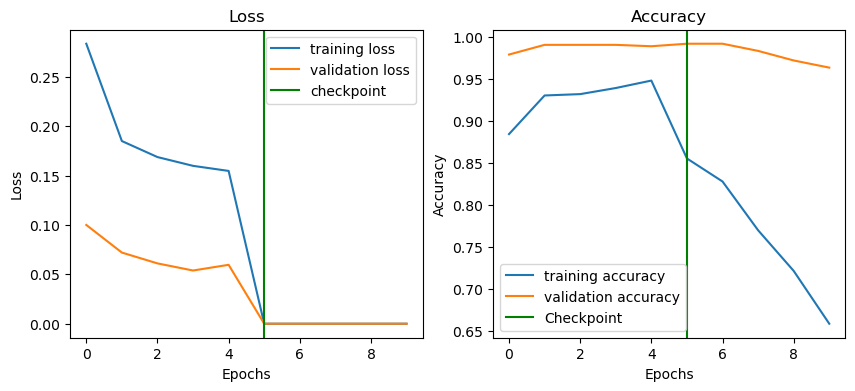

In [73]:
plot_combined_history(cd_history, history_fine_tuned)

Seems like the loss has approached zero, but the accuracy metrics do not directly co-relate with the loss. There could be some data issues within the network since the **`BatchNormalization`** layers are frozen. 

## 2. Unfreezing the last 5 layers.


## Recompile the model
1. Load the weights from initial epochs
2. Modify the mobile net architecture tp unfreeze bottom 2 Batch Normalization layers
3. Fit and Evaluate

In [74]:
# Reload saved checkpoint during feature extraction/inference
cd_classifier.load_weights(checkpoint_path)

In [80]:
def display_layers_trainable(model):
    """
    Loop thorugh the model layers and display layer number, name and trainable status.
    """
    for ind, layer in enumerate(model.layers):
        print(f"Layer number : {ind + 1}\tLayer Name: {layer.name}\tLayer Trainable: {layer.trainable}")

In [81]:
# Modifying the alst 5 layers to trainable (unfreezing)

mobile_net_base.trainable = False
for layer in mobile_net_base.layers[:-6:-1]:
    layer.trainable = True

# Check trainable layers and verify
display_layers_trainable(mobile_net_base)

Layer number : 1	Layer Name: input_1	Layer Trainable: False
Layer number : 2	Layer Name: Conv1	Layer Trainable: False
Layer number : 3	Layer Name: bn_Conv1	Layer Trainable: False
Layer number : 4	Layer Name: Conv1_relu	Layer Trainable: False
Layer number : 5	Layer Name: expanded_conv_depthwise	Layer Trainable: False
Layer number : 6	Layer Name: expanded_conv_depthwise_BN	Layer Trainable: False
Layer number : 7	Layer Name: expanded_conv_depthwise_relu	Layer Trainable: False
Layer number : 8	Layer Name: expanded_conv_project	Layer Trainable: False
Layer number : 9	Layer Name: expanded_conv_project_BN	Layer Trainable: False
Layer number : 10	Layer Name: block_1_expand	Layer Trainable: False
Layer number : 11	Layer Name: block_1_expand_BN	Layer Trainable: False
Layer number : 12	Layer Name: block_1_expand_relu	Layer Trainable: False
Layer number : 13	Layer Name: block_1_pad	Layer Trainable: False
Layer number : 14	Layer Name: block_1_depthwise	Layer Trainable: False
Layer number : 15	Layer

In [82]:
# Compile the model keeping all hyper parameters same as previous experiment

cd_classifier.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=["accuracy"]
)

#fit the model
history_exp2 = cd_classifier.fit(
    train_data,
    initial_epoch=INIT_EPOCHS,
    epochs=fine_tuning_epoch,
    validation_data=validation_data,
    validation_steps=int(0.15 * len(validation_data))
)

Epoch 6/10


78/78 [==============================] - 66s 505ms/step - loss: 0.0000e+00 - accuracy: 0.5690 - val_loss: 0.0000e+00 - val_accuracy: 0.7528
Epoch 7/10
78/78 [==============================] - 36s 465ms/step - loss: 0.0000e+00 - accuracy: 0.2322 - val_loss: 0.0000e+00 - val_accuracy: 0.3438
Epoch 8/10
78/78 [==============================] - 36s 465ms/step - loss: 0.0000e+00 - accuracy: 0.2004 - val_loss: 0.0000e+00 - val_accuracy: 0.1705
Epoch 9/10
78/78 [==============================] - 38s 483ms/step - loss: 0.0000e+00 - accuracy: 0.1988 - val_loss: 0.0000e+00 - val_accuracy: 0.1648
Epoch 10/10
78/78 [==============================] - 37s 472ms/step - loss: 0.0000e+00 - accuracy: 0.1988 - val_loss: 0.0000e+00 - val_accuracy: 0.1648
